<a href="https://colab.research.google.com/github/luca-arts/seeingtheimperceptible/blob/main/notebooks/skinRetouching/tests/face_smoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Face Smoothing Detection and Beautification


https://github.com/luca-arts/face-smoothing

1. Linking next cloud

In [1]:
# we'll link the dataset from next-cloud
!curl https://raw.githubusercontent.com/luca-arts/seeingtheimperceptible/main/notebooks/database_mod.py -o /content/database_mod.py

from database_mod import *

link_nextcloud()

nextcloud = '/content/database/'

input_folder, output_folder = create_io(database=nextcloud,topic='skinRetouching',library='FS')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2235  100  2235    0     0  10849      0 --:--:-- --:--:-- --:--:-- 10797
what's the username for nextcloud? colab
what's the password for user colab? ··········
0
Please enter the username to authenticate with server
https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ or hit enter for none.
  Username: Please enter the password to authenticate user colab with server
https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ or hit enter for none.
  Password:  
content of /etc/fstab: https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ /content/database davfs user,rw,auto 0 0


2. Clone Git repository

In [2]:
#@title clone repo and copy the ML models
import os
root_path = '/content/FS'

# clone the repository
if not os.path.exists('FS'):
  !git clone https://github.com/luca-arts/face-smoothing/ {root_path} #forked repository with patches

# add Caffe model from Facedetection
import shutil
model_src = os.path.join(nextcloud,'faceDetection/model')
for i in os.listdir(model_src):
  shutil.copy2(os.path.join(model_src,i),os.path.join(root_path,'models'))

Cloning into '/content/FS'...
remote: Enumerating objects: 661, done.
remote: Counting objects: 100% (235/235), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 661 (delta 119), reused 218 (delta 109), pack-reused 426
Receiving objects: 100% (661/661), 39.85 MiB | 28.86 MiB/s, done.
Resolving deltas: 100% (331/331), done.


3. Configuration file

we read the yaml config file and set the wanted `conf_threshold` 

In [4]:
#@title imports for config file
# imports
import os, sys
import argparse
!pip -q install  PyYAML==5.3.1
import yaml
import time

import cv2
import matplotlib
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('./FS'))
if module_path not in sys.path:
    sys.path.append(module_path)
from detector.detect import detect_face
from detector.smooth import smooth_face
from utils.image import (load_image, 
                         save_image, 
                         save_steps, 
                         check_img_size,
                         get_height_and_width,
                         process_image,
                         check_if_adding_bboxes)
from utils.video import (split_video,
                         process_video)
from utils.types import (is_image,
                         is_video,
                         is_directory)
from infer import load_configs, parse_args
import traceback

4. define model & threshold

In [6]:
#@title use the original model (True) or the newer one (False)?
#we use a boolean to implement the original neural net (True) or the one from face detection (False)
orig_model=False #@param {type:"boolean"}

**conf_threshold** can be **max 0.5** 

otherwise we have no face detection on alot of images, min value needs to be properly tested for **min 0.1 <-> 0.2**

In [7]:
#@title conf threshold: how strict should the model be on detecting faces?
import yaml
from yaml.loader import SafeLoader
config_path =  root_path + '/configs/configs.yaml'
#@markdown ---
#@markdown ##### Define how confident we should be to decide if there's a face in an image:
conf_threshold = 0.35 #@param {type: "slider", min: 0, max:1, step: 0.05}
#@markdown ---
#@markdown ##### Define the filter parameters:
sigma_1 = 0.35 #@param {type: "slider", min: 0, max:1, step: 0.05}
sigma_2 = 0.5 #@param {type: "slider", min: 0, max:1, step: 0.05}
filter_diam = 15 #@param {type: "slider", min: 0, max:30, step: 1}
if orig_model:
  model_file = 'models/opencv_face_detector_uint8.pb'
  cfg_file = 'models/opencv_face_detector.pbtxt'
else:
  cfg_file = 'FS/models/deploy.prototxt'
  model_file = 'FS/models/res10_300x300_ssd_iter_140000.caffemodel'
# Open the file and load the file
with open(config_path) as f:
    data = yaml.load(f, Loader=yaml.Loader)
    #update conf_threshold
    data['net']['conf_threshold'] = conf_threshold
    data['net']['model_file']=model_file
    data['net']['cfg_file']=cfg_file
    data['filter']['diameter']=filter_diam
    data['filter']['sigma_1']=sigma_1
    data['filter']['sigma_2']=sigma_2
    sorted_data = yaml.dump(data)
    #print(sorted_data)
#write the updated yml file back
with open(config_path, 'w') as f:
    yaml.dump(data, f)    

5. Execute script

In [ ]:
class fakeArgs:
  def __init__(self,input, output, config, show_detections):
      self.input = input
      self.output = output
      self.config = config
      self.show_detections = show_detections

args = fakeArgs(input_folder, output_folder, config_path, True)

cfg = load_configs(args.config)
# Load the network
if orig_model:
  net = cv2.dnn.readNetFromTensorflow(cfg['net']['model_file'], 
                                        cfg['net']['cfg_file'])
else:
  net = cv2.dnn.readNetFromCaffe(cfg['net']['cfg_file'], 
                                        cfg['net']['model_file'])

input_file = args.input

try:  
  # If file is a compatible image file
  if is_image(input_file):
      # Load image
      input_img = load_image(input_file)
      # Process image
      img_steps = process_image(input_img, cfg, net)
      # Save final image to specified output filename
      out_filename = os.path.join(output_folder, cfg['image']['output'])
      # Check for --show-detections flag
      output_img = check_if_adding_bboxes(args, img_steps)
      # Save image
      img_saved = save_image(out_filename, output_img)
  # If input_file is a dir
  elif is_directory(input_file):
      # For each file in the dir
      for file in os.listdir(input_file):
          print('next image: ',file)
          try:
            # Join input dir and file name
            file_path = os.path.join(input_file, file)
            # If file is a compatible video file
            if is_video(file_path):
                # Process video
                process_video(file_path, args, cfg, net)
            # If file is a compatible image file    
            if is_image(file_path):
                # Load image
                input_img = load_image(file_path)
                # Process image
                img_steps = process_image(input_img, cfg, net)
                if(img_steps != None):
                  print("saving image ",file_path)
                  # Save final image to specified output filename
                  out_filename = os.path.join(args.output, file)
                  print(out_filename)
                  # Check for --show-detections flag
                  output_img = check_if_adding_bboxes(args, img_steps)
                  # Save image
                  img_saved = save_image(out_filename, output_img)
          except UnboundLocalError as e:
            print('no face detected?', e)
            traceback.print_exc()
except ValueError:
    print('Input must be a valid image, video, or directory.')

next image:  LB_0001.jpg
Face detected: [320, 131, 395, 237]
saving image  /content/database/skinRetouching/input/LB_0001.jpg
/content/database/skinRetouching/FS/LB_0001.jpg
next image:  LB_0002.jpg
next image:  LB_0003.jpg
Face detected: [338, 159, 406, 265]
saving image  /content/database/skinRetouching/input/LB_0003.jpg
/content/database/skinRetouching/FS/LB_0003.jpg
next image:  LB_0004.jpg
next image:  LB_0005.jpg
Face detected: [331, 132, 407, 240]
saving image  /content/database/skinRetouching/input/LB_0005.jpg
/content/database/skinRetouching/FS/LB_0005.jpg
next image:  LB_0006.jpg
Face detected: [299, 130, 370, 234]
saving image  /content/database/skinRetouching/input/LB_0006.jpg
/content/database/skinRetouching/FS/LB_0006.jpg
next image:  LB_0007.jpg
Face detected: [373, 115, 440, 222]
saving image  /content/database/skinRetouching/input/LB_0007.jpg
/content/database/skinRetouching/FS/LB_0007.jpg
next image:  LB_0008.jpg
Face detected: [262, 111, 335, 210]
saving image  /cont

In [ ]:
# This is the old way of calling the framework
# %cd /content/FS
# !python3 '/content/FS/infer.py' --input {input_folder} --output {output_folder} --config {config_path} --show-detections

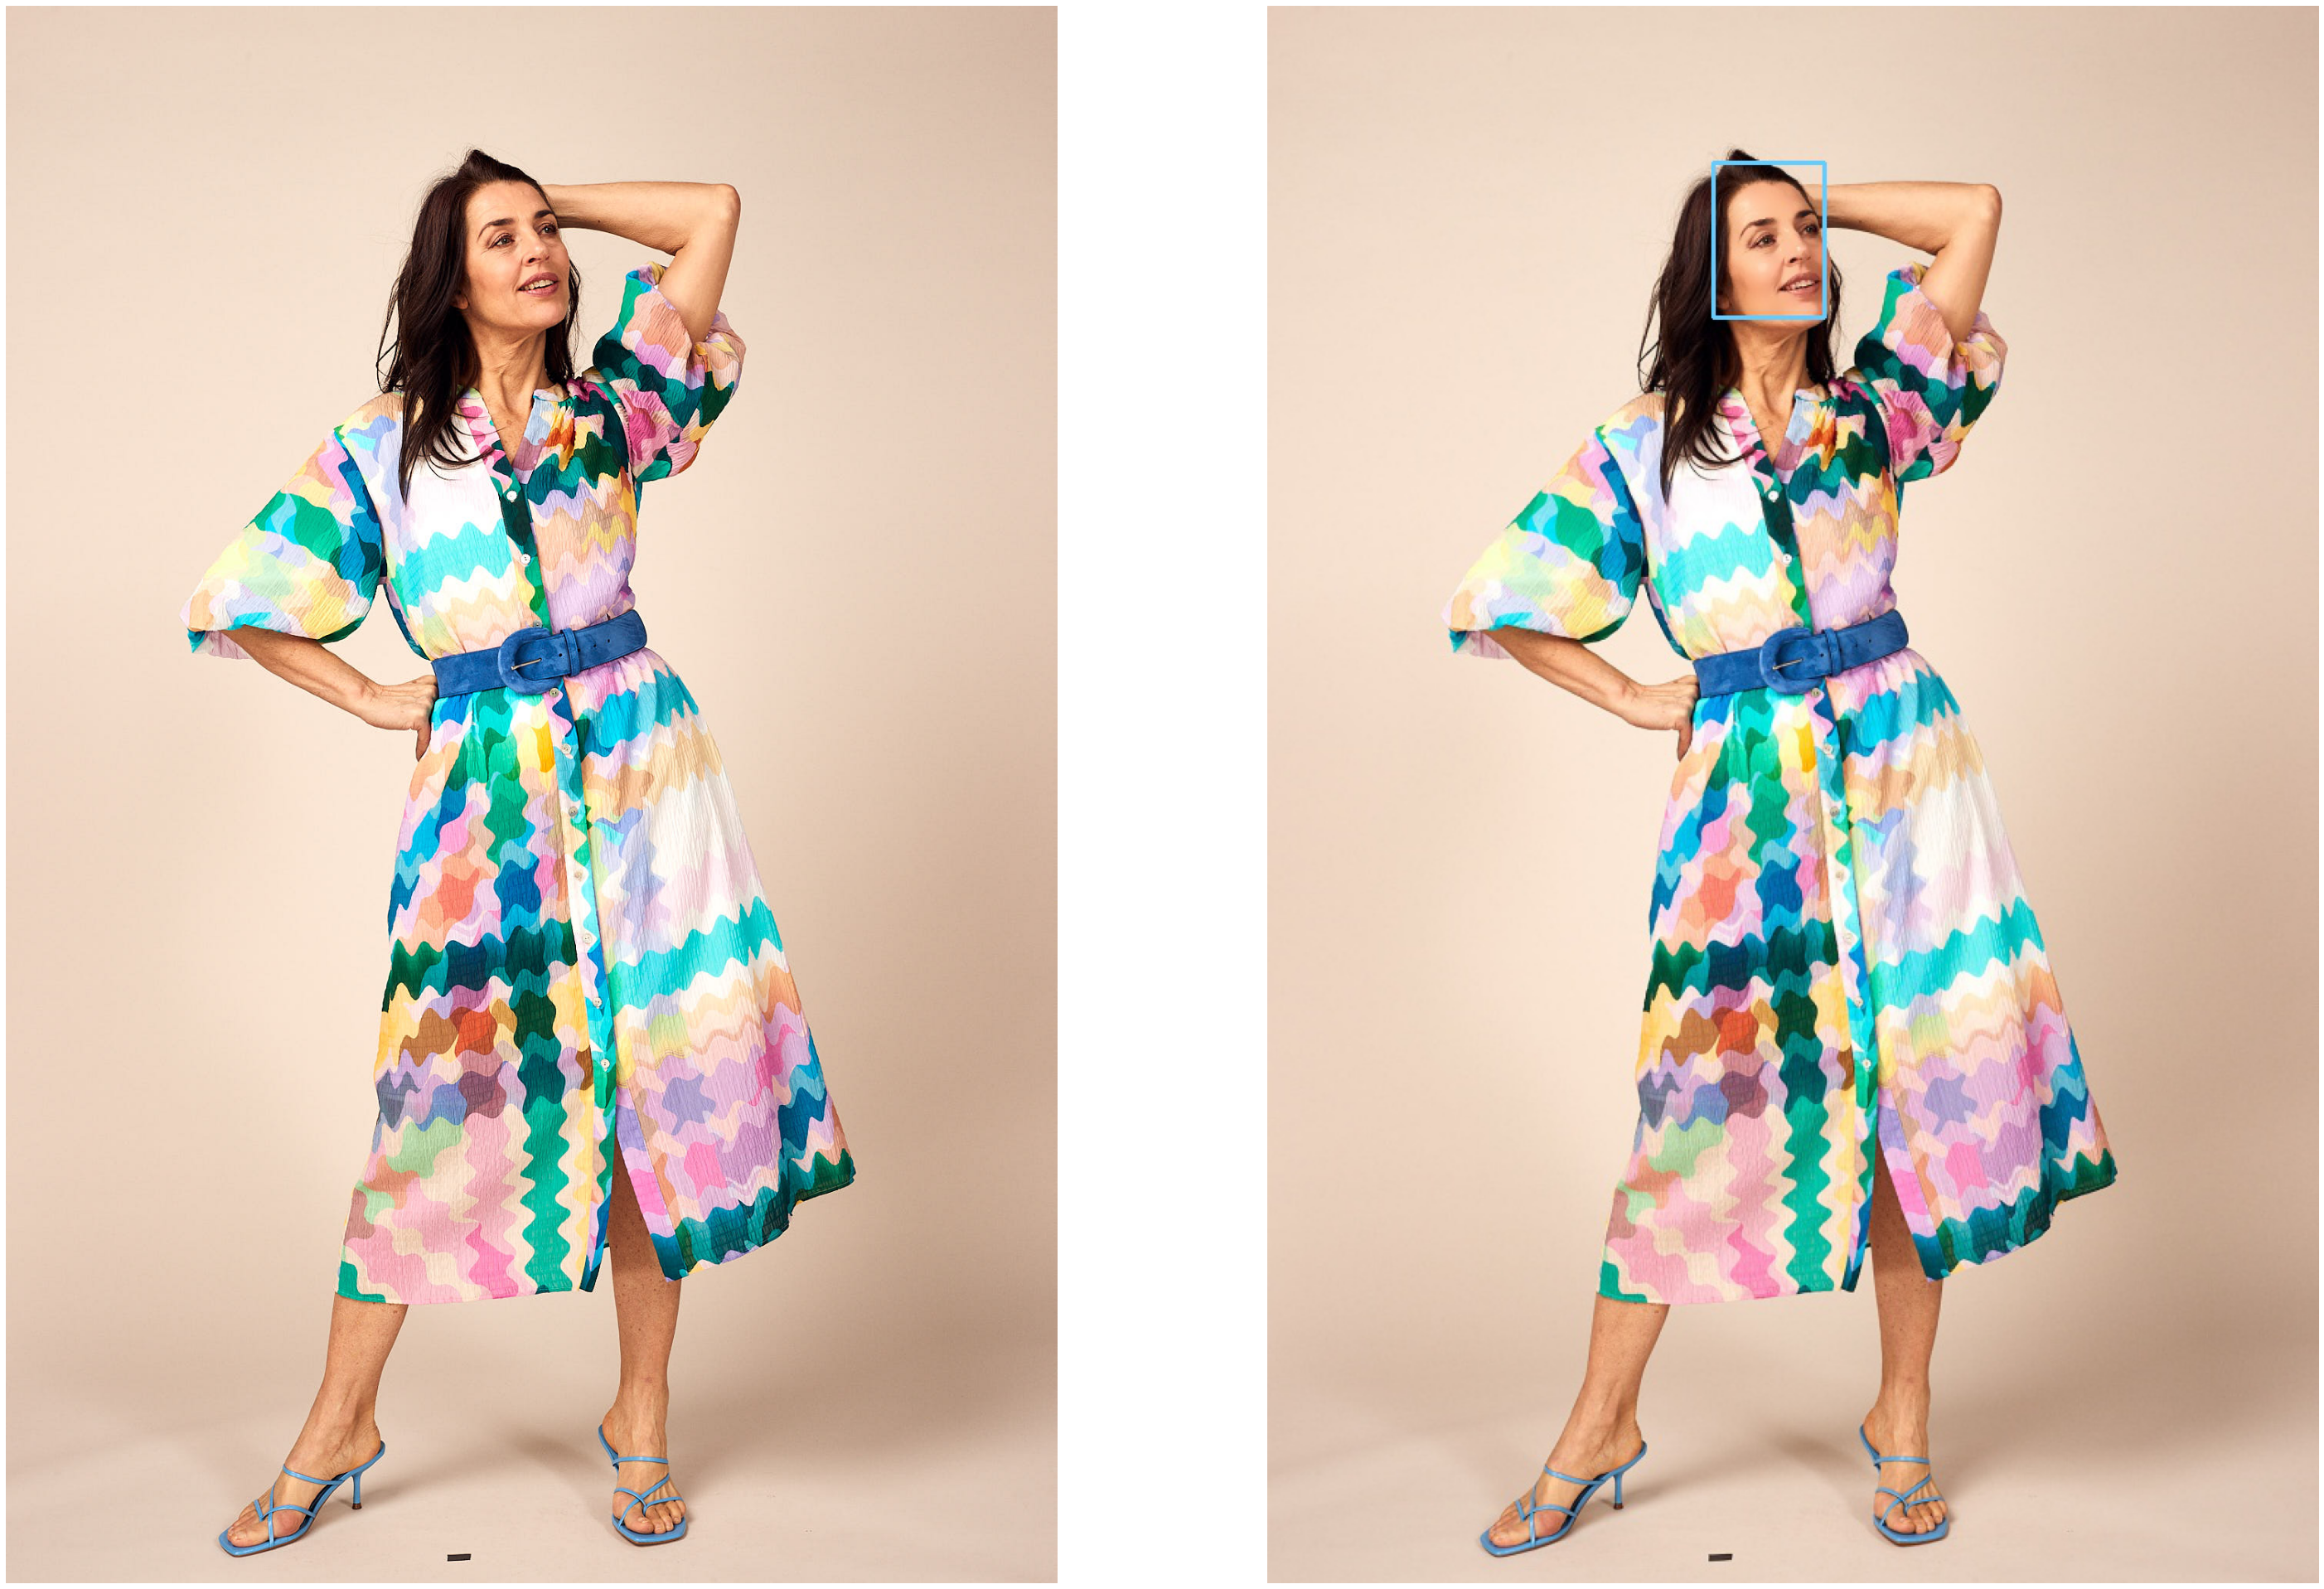

In [ ]:
#@title visualise the differences
# inits
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

oFS_files = glob.glob(output_folder + '/*.jpg')
oFS_files.sort()

vis_element = 7 #@param {type:"slider", min:0,max:10, step:1}


img_name = oFS_files[vis_element].split('/')[-1]

def visualise_face_smoothing(name, orig_dir, retouch_dir):
  img_retouch = mpimg.imread(os.path.join(retouch_dir,img_name))
  img_orig = mpimg.imread(os.path.join(orig_dir,img_name))
  fig, ax = plt.subplots(1, 2,figsize=(50, 100))
  ax[0].imshow(img_orig, aspect='equal')
  ax[0].axis('off')
  ax[1].imshow(img_retouch, aspect='equal')
  ax[1].axis('off')
  fig.show()

visualise_face_smoothing(img_name, input_folder, output_folder)

In [ ]:
oFS_files[2]

'/content/database/skinRetouching/FS/LB_0009.jpg'